In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [66]:
import os, sys, shutil, time, os.path as osp, logging, numpy as np
import gluehgcalpvcnn
import torch
import matplotlib.pyplot as plt, cycler
import matplotlib

In [3]:
logger = logging.getLogger('glue')

In [4]:
# This is a very ugly fix
HGCAL_LDRD_PATH = osp.abspath('hgcal_ldrd/src')
PVCNN_PATH = osp.abspath('pvcnn')
sys.path.append(HGCAL_LDRD_PATH)
from datasets.hitgraphs import HitGraphDataset
# Make sure datasets import is from hgcal_ldrd
# Then add pvcnn to the path
sys.path.append(PVCNN_PATH)

In [74]:
script = gluehgcalpvcnn.LindseysTrainingScript(debug=False)
# script.load_checkpoint = 'training-Mar05-epoch-1-14/output/checkpoints/model_checkpoint_PVConvForHGCAL_2562244_9c8b11eb88_klijnsma_014.pth.tar'
script.load_checkpoint = 'training-Mar06-epoch-15-29/output/checkpoints/model_checkpoint_PVConvForHGCAL_2562244_9c8b11eb88_klijnsma_014.pth.tar'
trainer = script.get_trainer()

In [75]:
from torch_geometric.data import DataLoader
full_dataset, train_dataset, valid_dataset = script.get_full_dataset()
# Use just a few events for testing
# valid_dataset = torch.utils.data.Subset(valid_dataset, list(range(3)))
valid_loader = DataLoader(valid_dataset, batch_size=script.valid_batch_size, shuffle=False)

In [76]:
class Event():
    @classmethod
    def from_batch(cls, data, batch_output):
        if data.x.is_cuda:
            X = data.x.cpu().numpy()
            target = data.y_nodes.cpu().numpy()
        else:
            X = data.x.numpy()
            target = data.y_nodes.numpy()
        return cls(
            X = X, target = target,
            output_probabilities = batch_output.cpu().numpy()
            )
    
    def __init__(self, X, target, output_probabilities):
        self.X = X
        self.target = target
        self.output_probabilities = output_probabilities
        self.output = np.argmax(self.output_probabilities, axis=1)
        self.num_classes = self.output_probabilities.shape[1]
        self.num_hits = self.X.shape[0]
        
class EventFactory():
    def __init__(self, loader, max_events=None):
        self.loader = loader
        self.max_events = max_events
        self.do_tqdm = True
        
    def __iter__(self):
        with torch.no_grad():
            if self.do_tqdm:
                total = len(self.loader.dataset)
                if not(self.max_events is None) and self.max_events < total:
                    total = self.max_events
                iterator = tqdm(enumerate(self.loader), total=total)
            else:
                iterator = enumerate(self.loader)
            
            for i, data in iterator:
                if not(self.max_events is None) and i >= self.max_events: break
                batch_input = data.to(trainer.device)
                batch_target = data.y_nodes.type(torch.LongTensor).to(trainer.device)
                batch_output = trainer.model(batch_input)
                yield Event.from_batch(data, batch_output)                

In [72]:
class PlotEventDisplay():
    def __init__(self, event):
        self.event = event

    def plot_output(self, output, title=None, savefig=None):
        fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(20,12))        
        fig.set_facecolor('white')
        if title: fig.suptitle(title, fontsize=28)
        
        e_max = np.max(self.event.X[:,4])
        e_normed = 100.*np.tanh(self.event.X[:,4]/e_max)
        
        color_cycler = cycler.cycler(color=['b', 'r', 'g', 'y', 'm', 'c'])()
        
        for i_cat in range(self.event.num_classes):
            color = next(color_cycler)['color']
            X = self.event.X[output == i_cat]
            ax0.scatter(X[:,0], X[:,2], s=(e_normed), c=color)
            ax1.scatter(X[:,1], X[:,2], s=(e_normed), c=color)

        ax0.legend(['Noise', 'HAD', 'EM', 'MIP'], prop={'size': 24})
        fontsize = 24
        ax0.set_xlabel('x [cm]', fontsize=fontsize)
        ax0.set_ylabel('layer', fontsize=fontsize)
        ax1.set_xlabel('y [cm]', fontsize=fontsize)
        ax1.set_ylabel('layer', fontsize=fontsize)
        ax0.tick_params(axis='both', which='major', labelsize=20)
        ax1.tick_params(axis='both', which='major', labelsize=20)
        if savefig:
            fig.savefig(savefig)
            plt.close(fig)

    def plot_prediction(self, savefig=None):
        return self.plot_output(self.event.output, 'Prediction', savefig)
    
    def plot_truth(self, savefig=None):
        return self.plot_output(self.event.target, 'Truth', savefig)

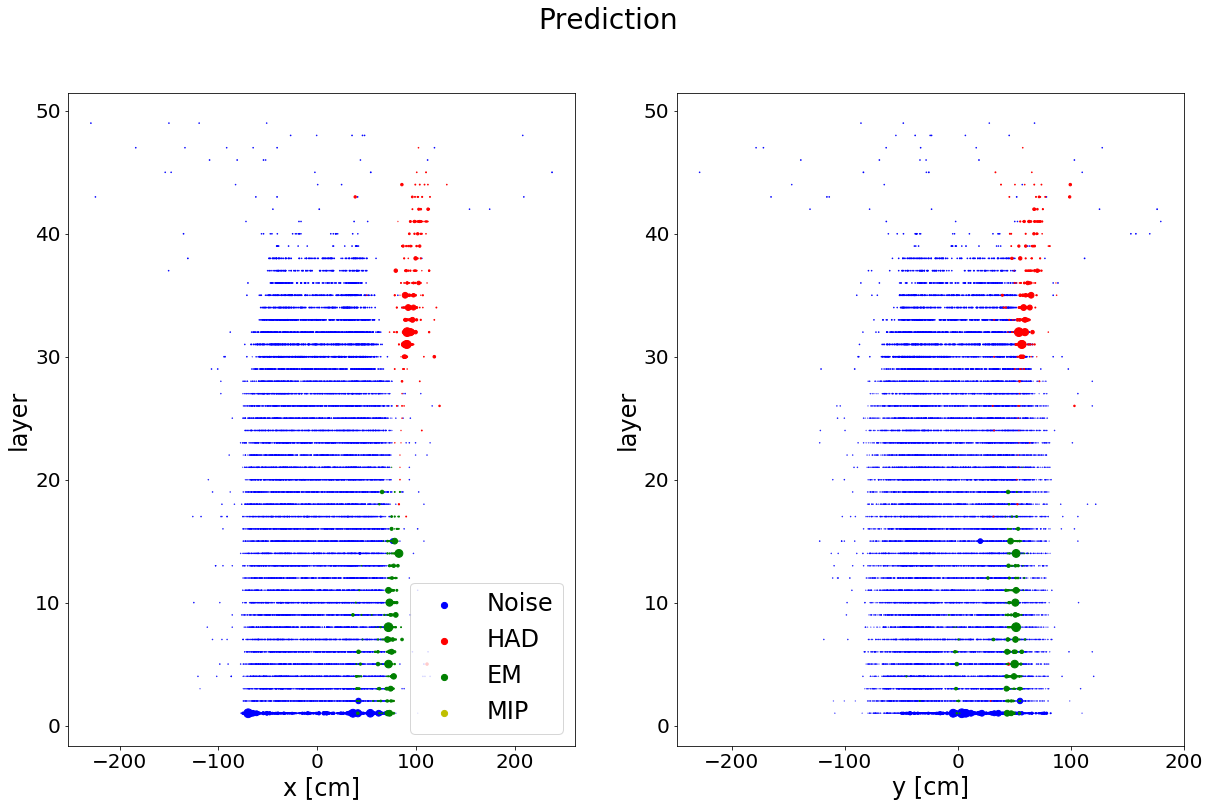

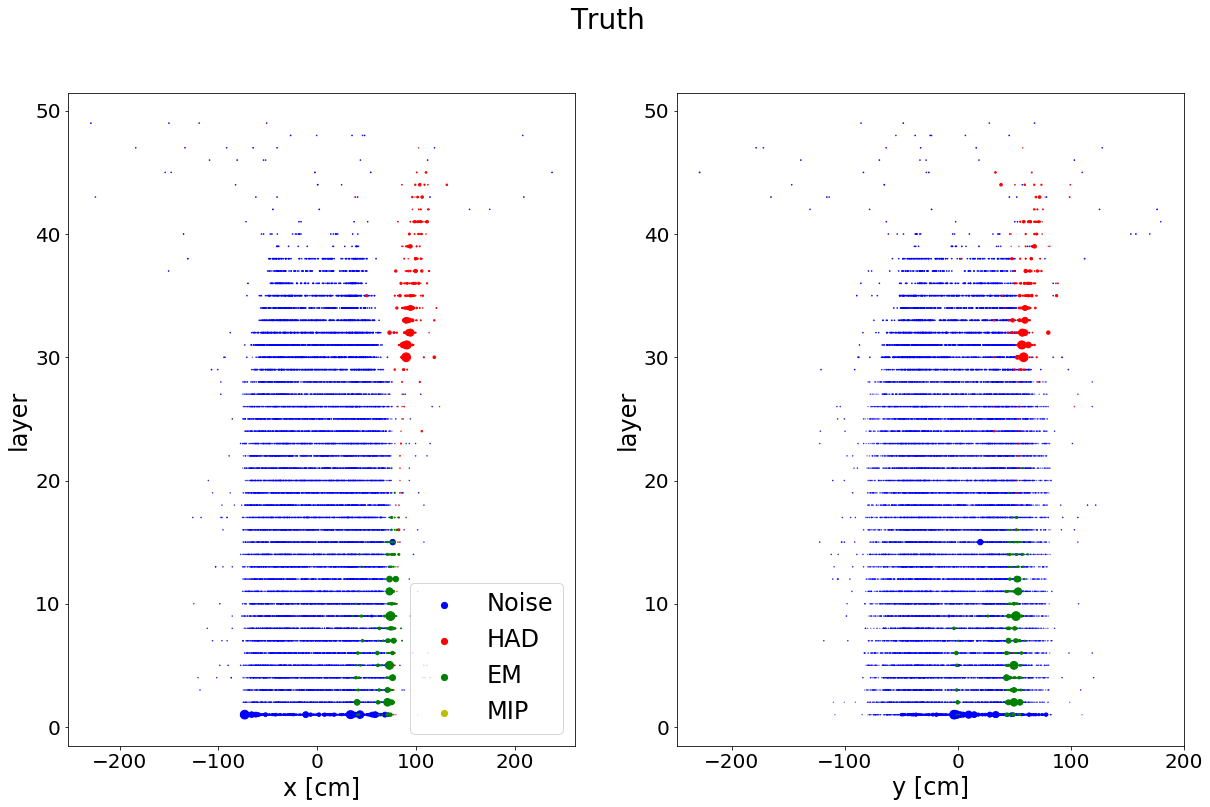

In [77]:
for event in EventFactory(valid_loader):
    plot = PlotEventDisplay(event)
    break
    
plot.plot_prediction()
plot.plot_truth()

In [78]:
if not osp.isdir('eventdisplays'): os.makedirs('eventdisplays')

backend_ =  matplotlib.get_backend() 
matplotlib.use("Agg")  # Prevent showing stuff

for i_event, event in enumerate(EventFactory(valid_loader, max_events=100)):
    plot = PlotEventDisplay(event)
    plot.plot_prediction('eventdisplays/{0:03d}_pred.png'.format(i_event))
    plot.plot_truth('eventdisplays/{0:03d}_truth.png'.format(i_event))

matplotlib.use(backend_) # Reset backend

In [81]:
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm

class PlotStatistics():
    def __init__(self, loader):
        self.loader = loader
        self.num_classes = 4
        # self.n_events = 100
        self.n_events = None
        
    def events(self):
        return EventFactory(self.loader, self.n_events)
                
    def single_confusion_matrix(self, event):
        conf_mat = confusion_matrix(
            event.target, event.output,
            labels = np.arange(self.num_classes),
            # normalize = 'true'
            )
        # If there are zero events of a category, sklearn puts a zero
        # on the diagonal. That screws up averaging.
        # for i_cat in range(self.num_classes):
        #     if conf_mat[i_cat][i_cat] == 0.0:
        #         conf_mat[i_cat][i_cat] = 1.0
        return conf_mat
    
    def average_confusion_matrix(self):
        total_confusion_matrix = np.zeros((self.num_classes, self.num_classes))
        for event in self.events():
            total_confusion_matrix = np.add(
                total_confusion_matrix,
                self.single_confusion_matrix(event)
                )
        sums = total_confusion_matrix.sum(axis=1)
        return total_confusion_matrix / sums
    
    def _energy_collection_perevent(self, event, i_cat):
        pred_energy = event.X[event.output == i_cat][:,4].sum()
        true_energy = event.X[event.target == i_cat][:,4].sum()
        return pred_energy/true_energy if true_energy > 0. else -1
    
    def get_energy_collection(self):
        energy_collection_per_cat = [ [] for i_cat in range(self.num_classes) ]
        for event in self.events():
            for i_cat in range(self.num_classes):
                energy_collection = self._energy_collection_perevent(event, i_cat)
                if energy_collection != -1:
                    energy_collection_per_cat[i_cat].append(energy_collection)
        return energy_collection_per_cat

    def plot_energy_collection_hist(self, energy_collection_per_cat=None, savefig=None):
        fig, axs = plt.subplots(2, 2, figsize=(12,12))
        color_cycler = cycler.cycler(color=['b', 'r', 'g', 'y', 'm', 'c'])()
        labels = [ 'Noise', 'HAD', 'EM', 'MIP' ]
        
        if energy_collection_per_cat is None:
            energy_collection_per_cat = self.get_energy_collection()
        
        for i_cat, ax in zip(range(self.num_classes), axs.ravel()):
            ax.hist(
                energy_collection_per_cat[i_cat],
                bins = np.linspace(0.5, 1.5, 50),
                histtype = u'step', label = labels[i_cat],
                **next(color_cycler)
                )
            ax.legend(fontsize=14)
            ax.set_ylabel('Count', fontsize=14)
            ax.set_xlabel('E_pred / E_true', fontsize=14)
            
        if savefig: fig.savefig(savefig, bbox_inches='tight')

plot = PlotStatistics(valid_loader)

In [80]:
plot.average_confusion_matrix()

array([[9.98510109e-01, 3.36939487e-02, 2.80979449e-02, 2.01913876e-02],
       [4.95986249e-04, 8.53690300e-01, 1.18697596e-01, 3.92822967e-02],
       [4.65489379e-04, 1.83524814e-01, 8.05634708e-01, 2.77511962e-03],
       [2.71483956e-05, 1.79025547e-03, 4.33616742e-04, 8.51866029e-01]])

In [82]:
# plot.n_events = 10
plot.n_events = None
energy_collection_per_cat = plot.get_energy_collection()

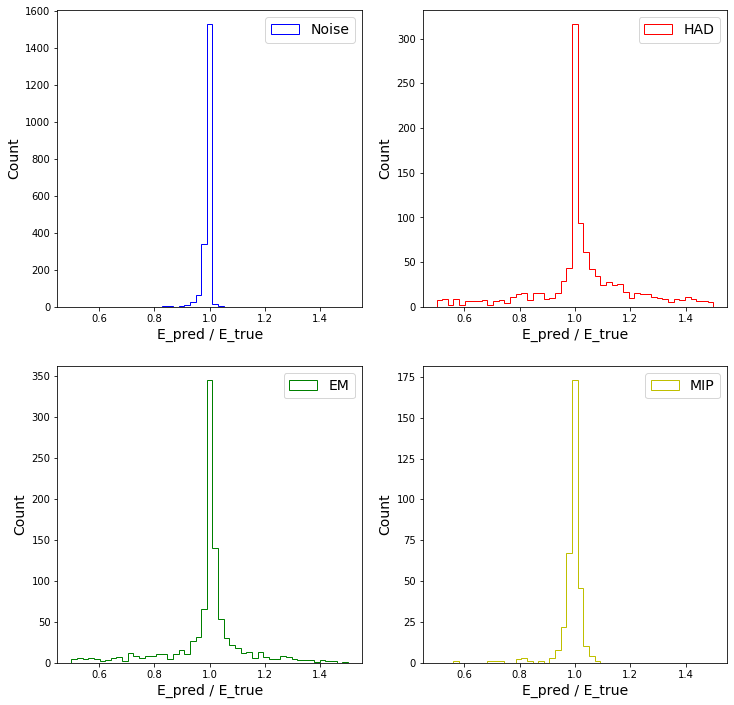

In [83]:
plot.plot_energy_collection_hist(energy_collection_per_cat, savefig='energycollection.pdf')

In [59]:


len(valid_loader.dataset)

2000